[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ryanfobel/utility-bill-scraper/blob/main/notebooks%2Fcanada%2Fon%2Fkitchener_utilities.ipynb)

# Introduction

This notebook will help you to download `pdf` statements and data from a [Kitchener Utilities](https://www.kitchenerutilities.ca) account. Launch an interactive version by clicking on the `Open in Colab` badge at the top of this page.

# Download data

To run the notebook, choose `Runtime/Run all` from the menu or press `CTRL`+`F9`. The notebook may promp you for inputs (e.g., authorization to conect to your google drive, username, password). If you're running this in Google Colab, the files will be automatically saved to your Google Drive in the folder `Google Drive/Colab Notebooks/data`.

In [1]:
try:
    import utility_bill_scraper
except ModuleNotFoundError:
    import subprocess
    import sys

    cmd = (
        f"{sys.executable} -m pip install --upgrade --upgrade-strategy "
        "only-if-needed "
        "git+https://github.com/ryanfobel/utility-bill-scraper.git"
    )
    subprocess.check_output(cmd, stderr=subprocess.STDOUT, shell=True).decode("utf-8")

from utility_bill_scraper import install_colab_dependencies

install_colab_dependencies(
    required_envs=["KITCHENER_UTILITIES_USER", "KITCHENER_UTILITIES_PASSWORD"]
)

%matplotlib inline

import datetime as dt
import os
import sys

from cycler import cycler
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np

from utility_bill_scraper import LIGHT_COLORMAP
import utility_bill_scraper.canada.on.kitchener_utilities as ku

# Plotting preferences
plt.rc("axes", prop_cycle=cycler("color", LIGHT_COLORMAP))
figsize = (12, 6)
bin_width = 0.9
alpha = 0.5
transparent = False
bbox_inches = "tight"
facecolor = "white"

# Load the `.env` file into the environment if it exists
load_dotenv()

api = ku.KitchenerUtilitiesAPI(
    user=os.getenv("KITCHENER_UTILITIES_USER"),
    password=os.getenv("KITCHENER_UTILITIES_PASSWORD"),
    data_path=os.getenv("DATA_PATH", os.path.join("..", "..", "..", "data")),
    google_sa_credentials=os.getenv("GOOGLE_SA_CREDENTIALS"),
    browser=os.getenv("BROWSER", "Firefox"),
)

# Get up to 24 statements (the most recent).
updates = api.update(24)
if updates is not None:
    print(f"{ len(updates) } statements_downloaded")
api.history("monthly").tail()

Download file from google drive(file_id=1-IYaB4IdO6rQnNmh-Fo8DyEm5OLQCruo, local_path=/tmp/tmp8kj7r896/monthly.csv
Upload file to google drive(file_id=1-IYaB4IdO6rQnNmh-Fo8DyEm5OLQCruo, local_path=/tmp/tmp8kj7r896/monthly.csv
0 statements_downloaded


,Account Number,Balance Forward,Gas & Water Charges,Gas Charges,Gas Consumption,Stormwater Rate Charges,Total,Water Charges,Water Consumption
Date,,,,,,,,,
2021-09-16,110159085.0,0.0,53.51,25.22,4.0,16.39,69.90,28.29,5.0
2021-10-18,110159085.0,0.0,85.91,40.63,42.0,16.39,102.30,45.28,8.0
2021-11-16,110159085.0,0.0,65.57,37.28,52.0,16.39,81.96,28.29,5.0
2021-12-14,110159085.0,0.0,131.84,92.23,208.0,16.39,148.23,39.61,7.0
2022-01-18,110159085.0,0.0,210.81,159.54,383.0,16.39,227.20,51.27,9.0


# Plotting

## Monthly consumption history

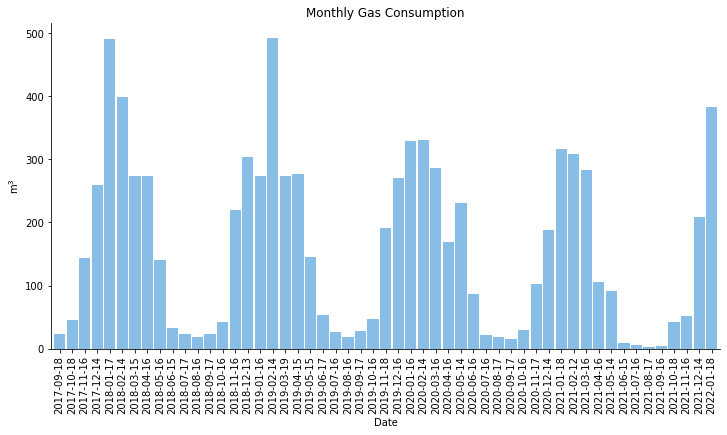

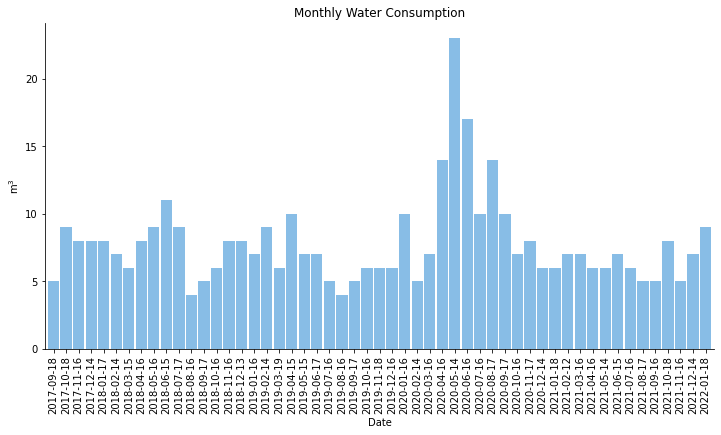

In [2]:
gas = api.history("monthly")

plt.figure(figsize=figsize)
gas["Gas Consumption"].plot.bar(
    width=bin_width,
    figsize=figsize,
)
plt.xticks(rotation=90)
plt.title("Monthly Gas Consumption")
plt.ylabel("m$^3$")
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
os.makedirs("images", exist_ok=True)
plt.savefig(
    os.path.join("images", "monthly_gas_consumption.png"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)
locs, labels = plt.xticks()
plt.xticks(locs, labels=[label.get_text().split(" ")[0] for label in labels]);
plt.figure(figsize=figsize)
gas["Water Consumption"].plot.bar(
    width=bin_width,
    figsize=figsize,
)
plt.xticks(rotation=90)
plt.title("Monthly Water Consumption")
plt.ylabel("m$^3$")
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
os.makedirs("images", exist_ok=True)
plt.savefig(
    os.path.join("images", "monthly_water_consumption.png"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)
locs, labels = plt.xticks()
plt.xticks(locs, labels=[label.get_text().split(" ")[0] for label in labels]);

## Annual CO2 emissions

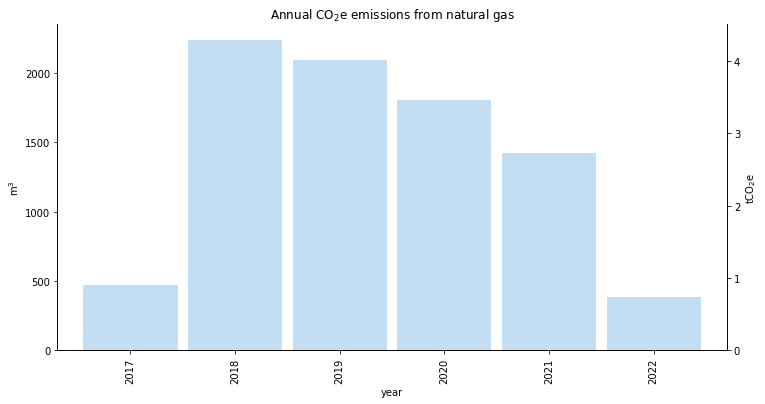

In [3]:
from utility_bill_scraper import GAS_KGCO2_PER_CUBIC_METER

gas["kgCO2"] = gas["Gas Consumption"] * GAS_KGCO2_PER_CUBIC_METER
gas["year"] = [date.year for date in gas.index]
gas["month"] = [date.month for date in gas.index]

plt.figure(figsize=figsize)
gas.groupby("year").sum()["Gas Consumption"].plot.bar(width=bin_width, alpha=alpha)
plt.ylabel("m$^3$")
ylim = plt.ylim()
ax = plt.gca()
ax2 = ax.twinx()
plt.ylabel("tCO$_2$e")
plt.ylim([GAS_KGCO2_PER_CUBIC_METER * y / 1e3 for y in ylim])
plt.title("Annual CO$_2$e emissions from natural gas")
ax.spines["top"].set_visible(False)
ax2.spines["top"].set_visible(False)
os.makedirs("images", exist_ok=True)
plt.savefig(
    os.path.join("images", "annual_co2_emissions_natural_gas.png"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

## CO2 emissions vs previous year

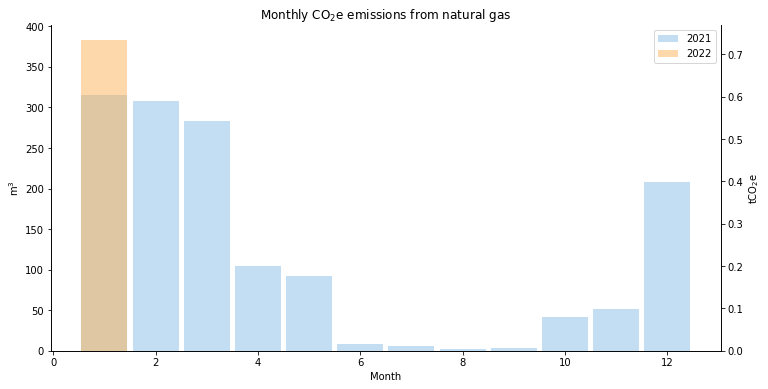

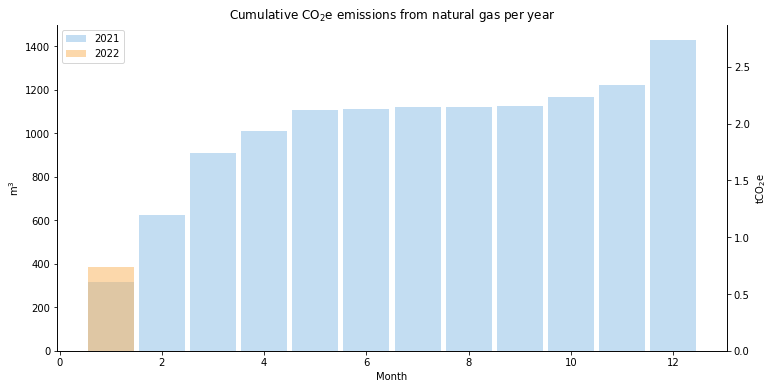

In [4]:
n_years_history = 1

plt.figure(figsize=figsize)
for year, df_year in gas.groupby("year"):
    if year >= dt.datetime.utcnow().year - n_years_history:
        df_year.sort_values("month", inplace=True)
        plt.bar(
            df_year["month"],
            df_year["Gas Consumption"],
            label=year,
            width=bin_width,
            alpha=alpha,
        )
plt.legend()
plt.ylabel("m$^3$")
plt.xlabel("Month")
ylim = plt.ylim()
ax = plt.gca()
ax2 = ax.twinx()
plt.ylabel("tCO$_2$e")
plt.ylim([GAS_KGCO2_PER_CUBIC_METER * y / 1e3 for y in ylim])
plt.title("Monthly CO$_2$e emissions from natural gas")
ax.spines["top"].set_visible(False)
ax2.spines["top"].set_visible(False)
os.makedirs("images", exist_ok=True)
plt.savefig(
    os.path.join("images", "monthly_co2_emissions_natural_gas.png"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)

plt.figure(figsize=figsize)
for year, df_year in gas.groupby("year"):
    if year >= dt.datetime.utcnow().year - n_years_history:
        df_year.sort_values("month", inplace=True)
        plt.bar(
            df_year["month"],
            np.cumsum(df_year["Gas Consumption"]),
            label=year,
            width=bin_width,
            alpha=alpha,
        )
plt.legend()
plt.ylabel("m$^3$")
plt.xlabel("Month")
ylim = plt.ylim()
ax = plt.gca()
ax2 = ax.twinx()
plt.ylabel("tCO$_2$e")
plt.ylim([GAS_KGCO2_PER_CUBIC_METER * y / 1e3 for y in ylim])
plt.title("Cumulative CO$_2$e emissions from natural gas per year")
ax.spines["top"].set_visible(False)
ax2.spines["top"].set_visible(False)
os.makedirs("images", exist_ok=True)
plt.savefig(
    os.path.join("images", "cumulative_co2_emissions_natural_gas.png"),
    bbox_inches=bbox_inches,
    transparent=transparent,
    facecolor=facecolor,
)